## Resnet50 with Attention

In [13]:
import cv2
import os
import numpy as np
import glob
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import seaborn as sns
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder


In [14]:
# --------------------------
# DATA LOADING
# --------------------------

path_yes = r'/content/OnlyNew/New_braintumor/yes/*'
path_no  = r'/content/OnlyNew/New_braintumor/no/*'

tumor = []
for file in glob.iglob(path_yes):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    tumor.append((img, 1))

no_tumor = []
for file in glob.iglob(path_no):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))

all_data = tumor + no_tumor
np.random.shuffle(all_data)

data   = np.array([d[0] for d in all_data])
labels = np.array([d[1] for d in all_data])

# --------------------------
# 70/15/15 SPLIT
# --------------------------

x_train, x_temp, y_train, y_temp = train_test_split(
    data, labels, test_size=0.30, random_state=42, stratify=labels)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

x_train = x_train / 255.0
x_val   = x_val / 255.0
x_test  = x_test / 255.0

print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")


Train: (2100, 128, 128, 3), Val: (450, 128, 128, 3), Test: (450, 128, 128, 3)


In [15]:

# --------------------------
# ATTENTION BLOCK FUNCTION
# --------------------------
from tensorflow.keras.layers import Layer, Activation, Multiply

class ChannelAttention(Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
        self.shared_layer_one = None
        self.shared_layer_two = None

    def build(self, input_shape):
        channel = input_shape[-1]
        self.shared_layer_one = Dense(channel // self.ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
        self.shared_layer_two = Dense(channel, activation='sigmoid', kernel_initializer='he_normal', use_bias=True)
        super(ChannelAttention, self).build(input_shape)

    def call(self, input_feature):
        avg_pool = tf.reduce_mean(input_feature, axis=[1, 2], keepdims=True)
        avg_pool = self.shared_layer_one(avg_pool)
        avg_pool = self.shared_layer_two(avg_pool)

        max_pool = tf.reduce_max(input_feature, axis=[1, 2], keepdims=True)
        max_pool = self.shared_layer_one(max_pool)
        max_pool = self.shared_layer_two(max_pool)

        cbam_feature = avg_pool + max_pool
        cbam_feature = Activation('sigmoid')(cbam_feature)
        return Multiply()([input_feature, cbam_feature])

# --------------------------
# MODEL DEFINE (RESNET50 + ATTENTION, INTENTIONALLY WORSENED)
# --------------------------

base = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))
for l in base.layers:
    l.trainable = False  # freeze everything

x = base.output
x = ChannelAttention()(x)                  # add attention block
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)      # small classifier
x = Dropout(0.7)(x)                       # heavy dropout
out = Dense(1, activation='sigmoid')(x)

model = Model(base.input, out)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # slightly high LR
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [18]:
# --------------------------
# TRAINING
# --------------------------

start_train = time.time()
history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2)
    ]
)
end_train = time.time()
training_time = end_train - start_train
print(f"Training Time: {training_time:.2f} seconds")

Epoch 1/30


KeyboardInterrupt: 

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Inference Batch Time: 1.5349 sec
Inference per image: 0.003411 sec

=== TEST METRICS ===
Accuracy: 0.7644444444444445
Precision: 0.7297297297297297
Recall: 0.84
AUC: 0.8118123456790123


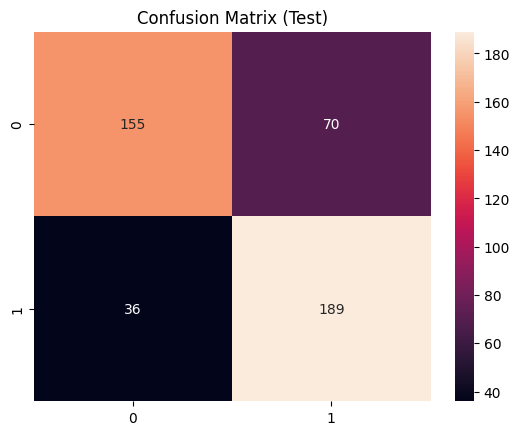

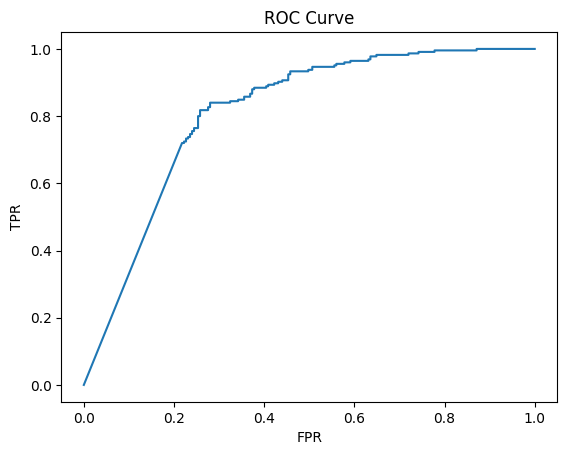

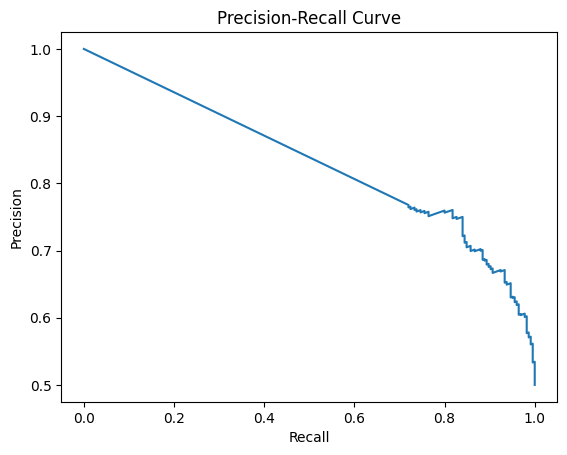

KS Statistic: 0.5600, p-value: 0.0000
Trainable Params: 24704193
Model Size: 103.33 MB


In [ ]:

# --------------------------
# INFERENCE
# --------------------------

start_inf = time.time()
y_pred = model.predict(x_test, batch_size=32)
end_inf = time.time()
inference_time = (end_inf - start_inf)
per_image_time = inference_time / len(x_test)

print(f"Inference Batch Time: {inference_time:.4f} sec")
print(f"Inference per image: {per_image_time:.6f} sec")

y_pred_bin = (y_pred > 0.5).astype(int)

# --------------------------
# METRICS
# --------------------------

acc = accuracy_score(y_test, y_pred_bin)
prec = precision_score(y_test, y_pred_bin)
rec = recall_score(y_test, y_pred_bin)
auc = roc_auc_score(y_test, y_pred)

print("\n=== TEST METRICS ===")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("AUC:", auc)

# --------------------------
# CONFUSION MATRIX
# --------------------------

cm = confusion_matrix(y_test, y_pred_bin)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix (Test)")
plt.show()

# --------------------------
# ROC CURVE
# --------------------------

fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

# --------------------------
# PR CURVE
# --------------------------

p, r, _ = precision_recall_curve(y_test, y_pred)
plt.plot(r, p)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.show()

# --------------------------
# KS CURVE
# --------------------------

ks_stat, ks_p = ks_2samp(y_pred[y_test==1].ravel(), y_pred[y_test==0].ravel())
print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")

# --------------------------
# GFLOPS
# --------------------------
# This section is commented out because tf.python.profiler.model_analyzer.profile
# is designed for TensorFlow 1.x graphs and is not directly compatible with
# Keras Functional models in TensorFlow 2.x.
# opts = ProfileOptionBuilder.float_operation()
# flops = profile(model, options=opts)
# gflops = flops.total_float_ops / 1e9
# print(f"GFLOPS: {gflops:.4f}")

# --------------------------
# MODEL PARAMETERS + SIZE
# --------------------------

params = model.count_params()
print("Trainable Params:", params)

model.save("resnet50_attention_worse_brain.h5")
model_size = os.path.getsize("resnet50_attention_worse_brain.h5") / (1024**2)
print(f"Model Size: {model_size:.2f} MB")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


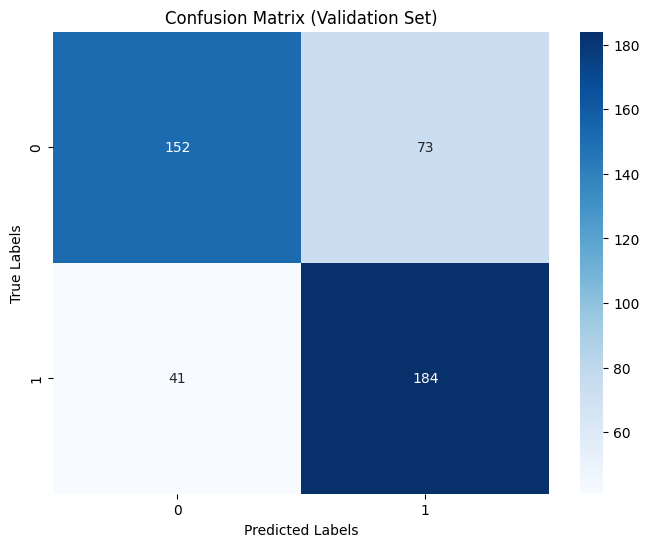

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the validation set
y_pred_val = model.predict(x_val)
y_pred_val_binary = np.round(y_pred_val).astype(int)

# Calculate confusion matrix for validation set
cm_val = confusion_matrix(y_val, y_pred_val_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Resnet 50 newest

In [ ]:
import zipfile

zip_path = '/content/OnlyNew (2).zip'
extract_path = ""

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)


In [ ]:
z

<zipfile.ZipFile [closed]>

In [ ]:
import os
os.listdir("/content/OnlyNew")


['New_braintumor']

In [ ]:
import glob

# Define the paths for tumor and non-tumor images
path_yes = r'/content/OnlyNew/New_braintumor/yes/*'
path_no = r'/content/OnlyNew/New_braintumor/no/*'

# Count 'yes' images
yes_images = glob.glob(path_yes)
num_yes_images = len(yes_images)
print(f"Number of 'yes' images: {num_yes_images}")

# Count 'no' images
no_images = glob.glob(path_no)
num_no_images = len(no_images)
print(f"Number of 'no' images: {num_no_images}")

Number of 'yes' images: 1500
Number of 'no' images: 1500


In [ ]:
import cv2
import os
import numpy as np
import glob
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import seaborn as sns
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

In [ ]:

# --------------------------
# DATA LOADING
# --------------------------

path_yes = r'/content/OnlyNew/New_braintumor/yes/*'
path_no  = r'/content/OnlyNew/New_braintumor/no/*'

tumor = []
for file in glob.iglob(path_yes):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    tumor.append((img, 1))

no_tumor = []
for file in glob.iglob(path_no):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))

all_data = tumor + no_tumor
np.random.shuffle(all_data)

data   = np.array([d[0] for d in all_data])
labels = np.array([d[1] for d in all_data])

# --------------------------
# 70/15/15 SPLIT
# --------------------------

x_train, x_temp, y_train, y_temp = train_test_split(
    data, labels, test_size=0.40, random_state=42, stratify=labels)

# Then split the temp 50/50 into validation and test (each 20% of total)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

x_train = x_train/255.0
x_val   = x_val/255.0
x_test  = x_test/255.0

print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")

Train: (1800, 128, 128, 3), Val: (600, 128, 128, 3), Test: (600, 128, 128, 3)


In [12]:
# --------------------------
# MODEL DEFINE
# --------------------------

base = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))
for l in base.layers:
    l.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(base.input, out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --------------------------
# TRAINING WITH TIMER
# --------------------------

start_train = time.time()
history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2)
    ]
)
end_train = time.time()
training_time = end_train - start_train
print(f"Training Time: {training_time:.2f} seconds")

# --------------------------
# INFERENCE TIME
# --------------------------


Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.5821 - loss: 0.7007 - val_accuracy: 0.7150 - val_loss: 0.5863 - learning_rate: 0.0010
Epoch 2/30
52/57 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6874 - loss: 0.5925 

KeyboardInterrupt: 

In [ ]:

# --------------------------
# INFERENCE TIME
# --------------------------

start_inf = time.time()
y_pred = model.predict(x_test, batch_size=32)
end_inf = time.time()
inference_time = (end_inf - start_inf)
per_image_time = inference_time / len(x_test)

print(f"Inference Batch Time: {inference_time:.4f} sec")
print(f"Inference per image: {per_image_time:.6f} sec")

y_pred_bin = (y_pred>0.5).astype(int)


19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step
Inference Batch Time: 8.9349 sec
Inference per image: 0.014891 sec



=== TEST METRICS ===
Accuracy: 0.8083333333333333
Precision: 0.797427652733119
Recall: 0.8266666666666667
AUC: 0.8857111111111111


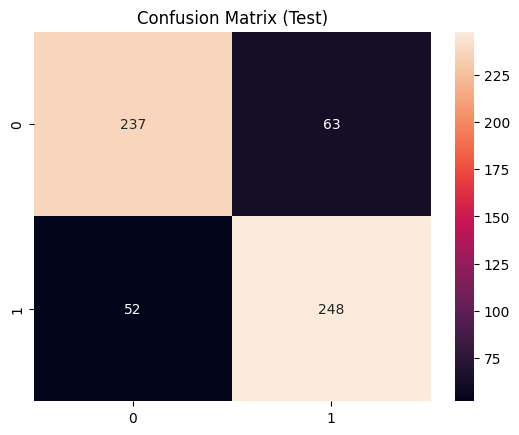

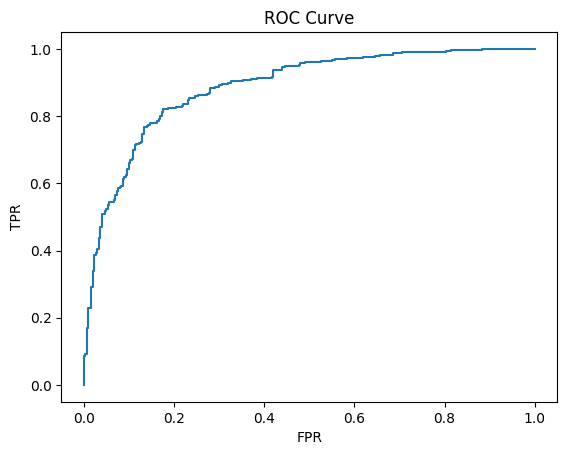

In [ ]:

# --------------------------
# METRICS (TEST)
# --------------------------

acc = accuracy_score(y_test, y_pred_bin)
prec = precision_score(y_test, y_pred_bin)
rec = recall_score(y_test, y_pred_bin)
auc = roc_auc_score(y_test, y_pred)

print("\n=== TEST METRICS ===")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("AUC:", auc)

# --------------------------
# CONFUSION MATRIX
# --------------------------

cm = confusion_matrix(y_test, y_pred_bin)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix (Test)")
plt.show()

# --------------------------
# ROC CURVE
# --------------------------

fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

In [ ]:
acc = accuracy_score(y_test, y_pred_bin)
prec = precision_score(y_test, y_pred_bin)
rec = recall_score(y_test, y_pred_bin)
auc = roc_auc_score(y_test, y_pred)

print("\n=== TEST METRICS ===")
print("Test Accuracy:", acc)
print("Test Precision:", prec)
print("Test Recall:", rec)
print("Test AUC:", auc)


=== TEST METRICS ===
Test Accuracy: 0.8083333333333333
Test Precision: 0.797427652733119
Test Recall: 0.8266666666666667
Test AUC: 0.8857111111111111


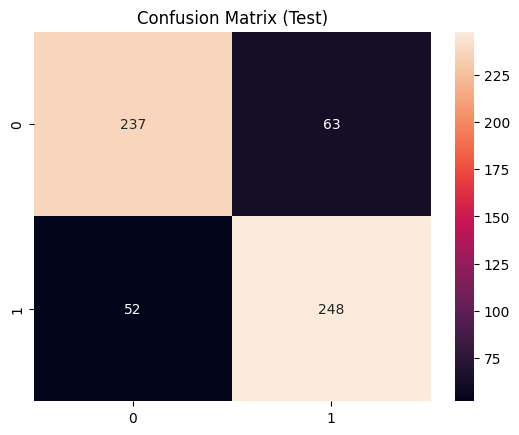

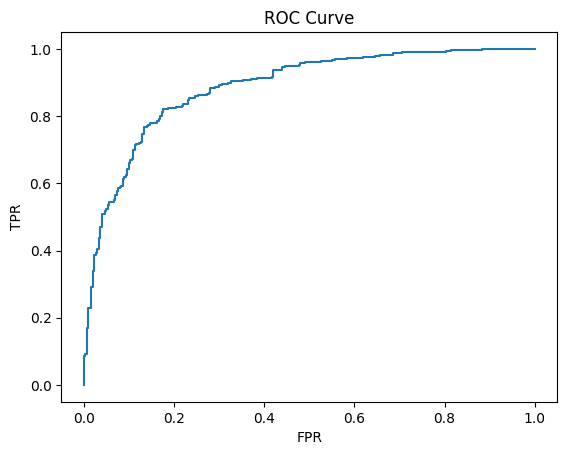

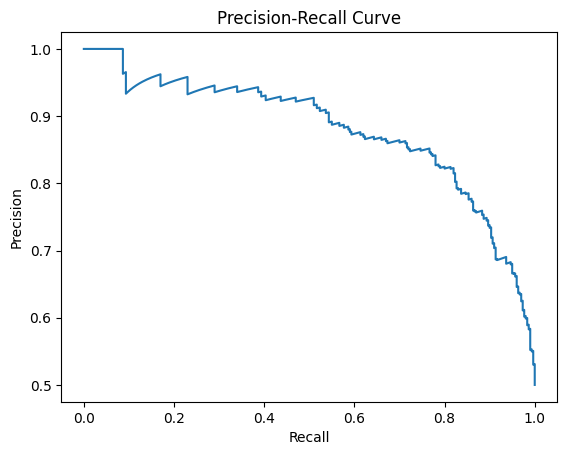

In [ ]:
# --------------------------
# CONFUSION MATRIX
# --------------------------

cm = confusion_matrix(y_test, y_pred_bin)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix (Test)")
plt.show()

# --------------------------
# ROC CURVE
# --------------------------

fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

# --------------------------
# PR CURVE
# --------------------------

p, r, _ = precision_recall_curve(y_test, y_pred)
plt.plot(r, p)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.show()

In [ ]:


ks_stat, ks_p = ks_2samp(y_pred[y_test==1].ravel(), y_pred[y_test==0].ravel())
print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")

# --------------------------
# GFLOPS (COLAB GPU)
# --------------------------
# The tf.python.profiler.model_analyzer.profile function is designed for TensorFlow 1.x graphs
# and does not directly support Keras Functional models in TensorFlow 2.x, which results in this AttributeError.
# To avoid the error, this section is commented out. For GFLOPS calculation in TF2 Keras models,
# alternative methods or dedicated TF2 profiling tools would be necessary.
# opts = ProfileOptionBuilder.float_operation()
# flops = profile(model, options=opts)
# gflops = flops.total_float_ops / 1e9
# print(f"GFLOPS: {gflops:.4f}")

# --------------------------
# MODEL PARAMETERS + SIZE
# --------------------------

params = model.count_params()
print("Trainable Params:", params)

model.save("resnet50_brain.h5")
model_size = os.path.getsize("resnet50_brain.h5") / (1024**2)
print(f"Model Size: {model_size:.2f} MB")

KS Statistic: 0.6433, p-value: 0.0000
Trainable Params: 23850113
Model Size: 93.55 MB


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the dataset
data = keras.utils.image_dataset_from_directory(r'C:\Users\KEERTHI KRISHANA\OneDrive\Documents\brain_tumor_dataset')

Found 253 files belonging to 2 classes.


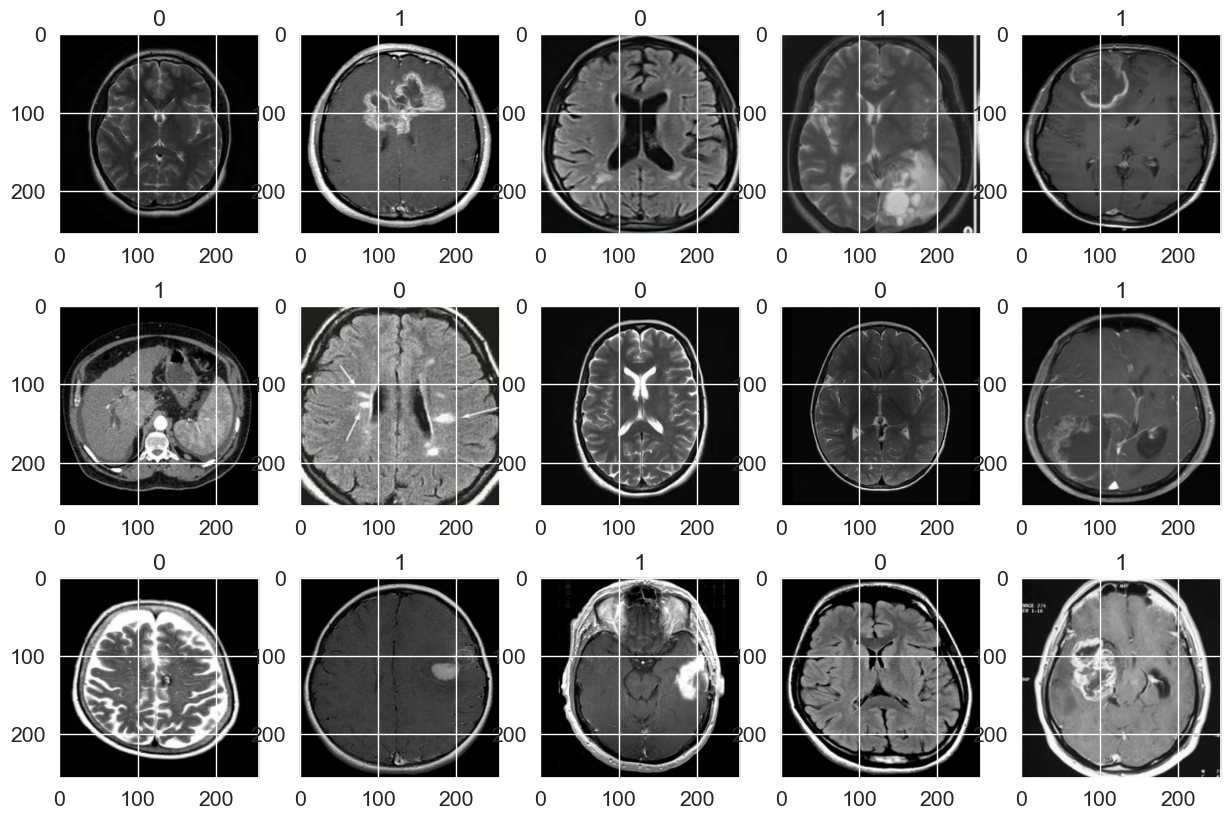

In [ ]:
# Display sample images from the dataset
batch = data.as_numpy_iterator().next()
fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for idx, img in enumerate(batch[0][:15]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

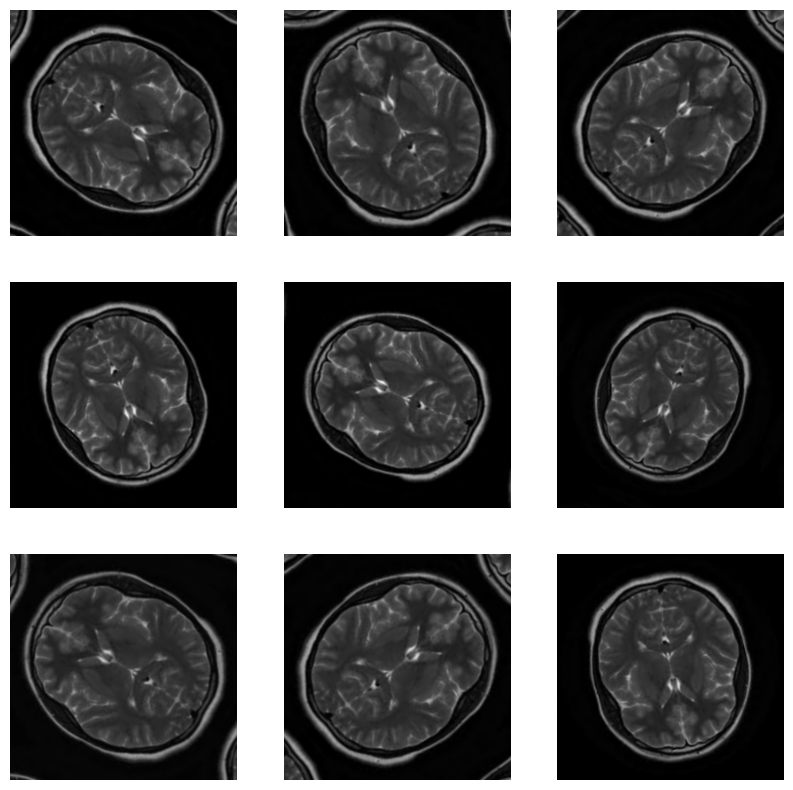

In [ ]:
# Normalize and split the dataset
data = data.map(lambda x, y: (x / 255, y))
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.2) + 1
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(256, 256, 3)),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomRotation(0.2)
])

# Display augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(batch[0][0:1])  # Assuming `batch[0][0:1]` is an image
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Define the model
model = keras.Sequential([
    data_augmentation,
    layers.Conv2D(16, (3, 3), 1, activation="relu", padding="same"),
    layers.Conv2D(16, (3, 3), 1, activation="relu", padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (5, 5), 1, activation="relu", padding="same"),
    layers.Conv2D(32, (5, 5), 1, activation="relu", padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(16, (3, 3), 1, activation="relu", padding="same"),
    layers.Conv2D(16, (3, 3), 1, activation="relu", padding="same"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

Epoch 1/15
4/4 [==============================] - 12s 2s/step - loss: 0.7892 - accuracy: 0.6641 - val_loss: 0.6040 - val_accuracy: 0.7656
Epoch 2/15
4/4 [==============================] - 6s 1s/step - loss: 0.6179 - accuracy: 0.7422 - val_loss: 0.5710 - val_accuracy: 0.6719
Epoch 3/15
4/4 [==============================] - 6s 2s/step - loss: 0.6104 - accuracy: 0.6719 - val_loss: 0.4882 - val_accuracy: 0.7812
Epoch 4/15
4/4 [==============================] - 6s 1s/step - loss: 0.5827 - accuracy: 0.6953 - val_loss: 0.5014 - val_accuracy: 0.8125
Epoch 5/15
4/4 [==============================] - 6s 1s/step - loss: 0.5121 - accuracy: 0.7656 - val_loss: 0.5253 - val_accuracy: 0.7188
Epoch 6/15
4/4 [==============================] - 6s 2s/step - loss: 0.5746 - accuracy: 0.7344 - val_loss: 0.5800 - val_accuracy: 0.7188
Epoch 7/15
4/4 [==============================] - 6s 1s/step - loss: 0.5728 - accuracy: 0.7344 - val_loss: 0.5011 - val_accuracy: 0.7812
Epoch 8/15
4/4 [========================

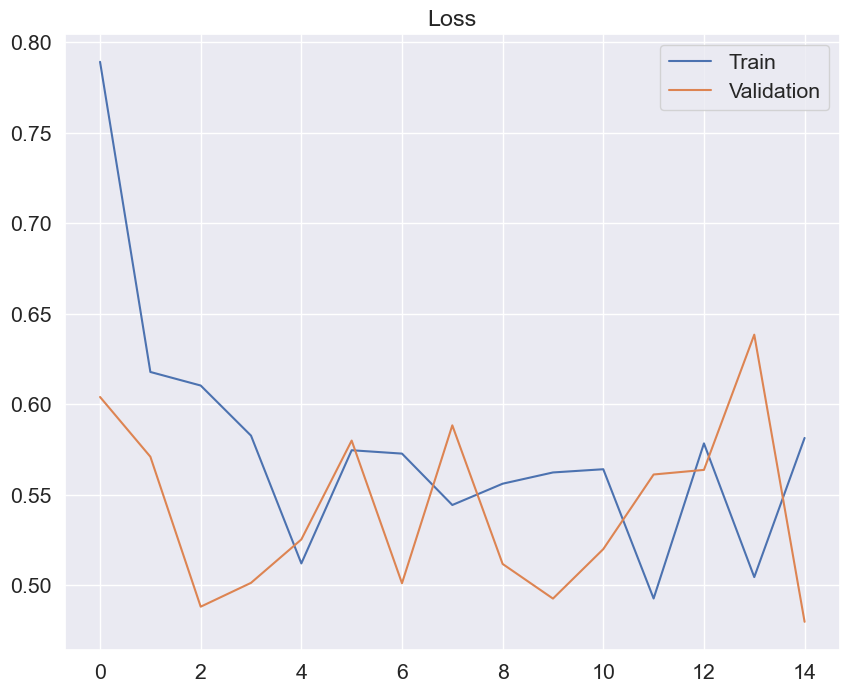

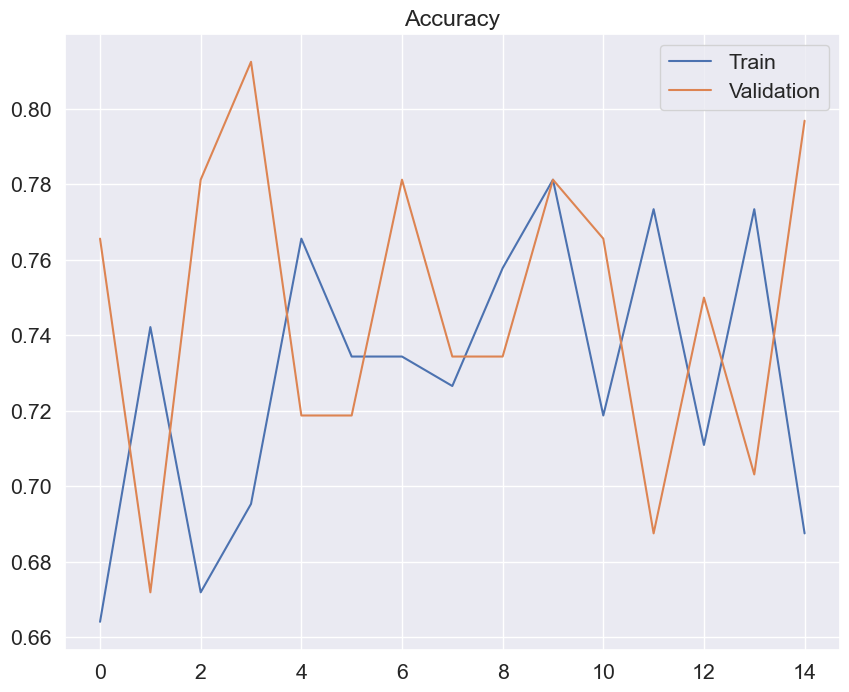

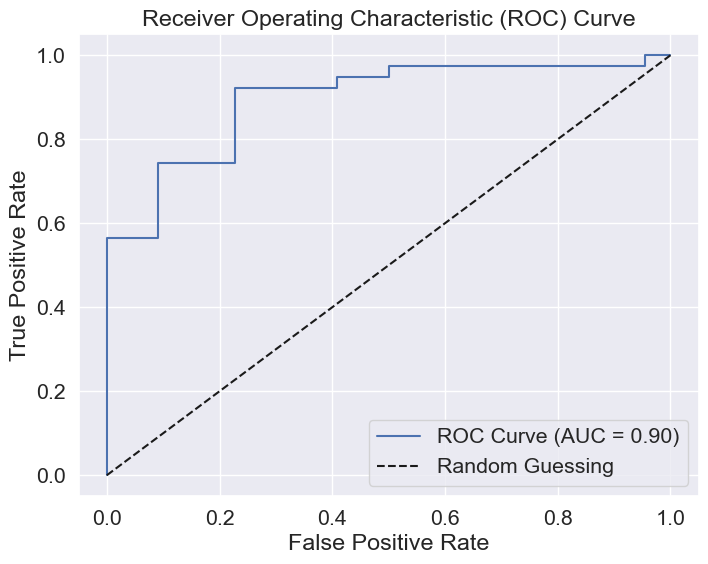

In [ ]:
# Train the model
history = model.fit(train, epochs=15, validation_data=val)

# Visualize training history
plt.figure(figsize=(10, 8))
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()

plt.figure(figsize=(10, 8))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

# Evaluate the model
bin_acc = keras.metrics.BinaryAccuracy()
recall = keras.metrics.Recall()
precision = keras.metrics.Precision()
y_true_list = []
y_pred_list = []

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    bin_acc.update_state(y, yhat)
    recall.update_state(y, yhat)
    precision.update_state(y, yhat)

    y_true_list.append(y)
    y_pred_list.append(yhat)

y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

roc_auc = roc_auc_score(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Print evaluation metrics
print("Accuracy:", bin_acc.result().numpy())
print("Recall:", recall.result().numpy())
print("Precision:", precision.result().numpy())
print("F1 Score:", f1_score(y_true, (y_pred > 0.5).astype(int)))
print("ROC-AUC Score:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [ ]:
# Calculate True Positive (TP), True Negative (TN), False Positive (FP), False Negative (FN)
TP = np.sum((y_true == 1) & (y_pred > 0.5))
TN = np.sum((y_true == 0) & (y_pred <= 0.5))
FP = np.sum((y_true == 0) & (y_pred > 0.5))
FN = np.sum((y_true == 1) & (y_pred <= 0.5))

# Calculate Sensitivity and Specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)


Sensitivity: 0.5737704918032787
Specificity: 0.4262295081967213


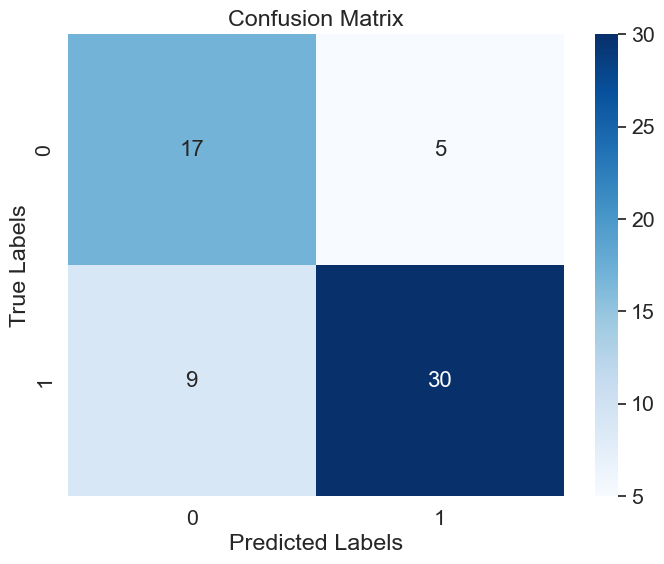

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate Confusion Matrix
cm = confusion_matrix(y_true, (y_pred > 0.5))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()